<a href="https://colab.research.google.com/github/WinniePretzel/Project/blob/master/%E2%80%9C%E2%80%9CNMA_project%E2%80%9D%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How face expressions were encoded in different brain area


In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
!pip install hmmlearn --quiet
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from hmmlearn import hmm
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     |████████████████████████████████| 368kB 3.3MB/s 


In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

---
# Visulize face, pupil area and running speed

beh_svd_time: (7018, 1000)
pupilArea: (7018, 1)
run: (7018, 1)


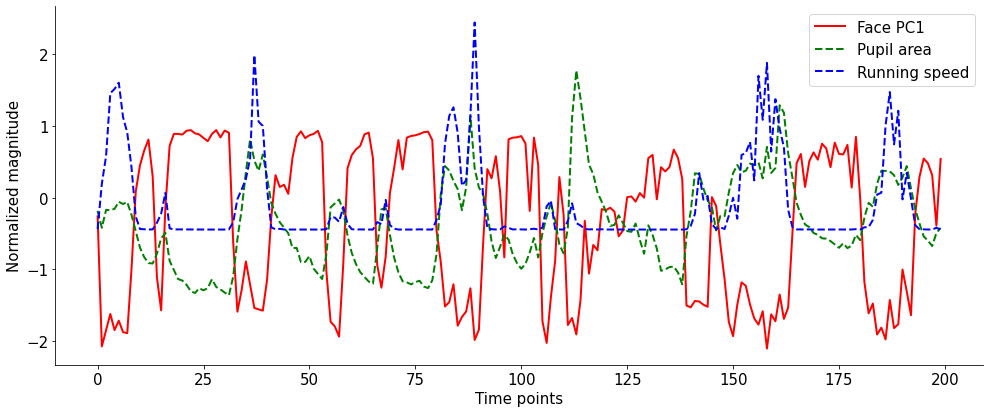

corr of face1 and area: -0.687 0.000
corr of face1 and run: -0.549 0.000
corr of run and area: 0.664 0.000


In [30]:
#@title Correlation among Face, Pupil Area and Running Speed
print('beh_svd_time:', dat['beh_svd_time'].shape)
print('pupilArea:', dat['pupilArea'].shape)
print('run:', dat['run'].shape)
from scipy import stats
def visualize_behavior(face1, area, run):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    face1 (numpy array of floats) : Vector of PC1 of mice face
    area (numpy array of floats) : Vector of area of mice pupil
    run (numpy array of floats) : Vector of running speed of mice

  Returns:
    Nothing.

  """
  fig = plt.figure(figsize=(14,6))
  ax = plt.subplot(1,1,1)
  plt.plot(face1[0:200], color='red', linewidth=2, 
           label='Face PC1')
  plt.plot(area[0:200], linestyle='dashed', color='green', 
           linewidth=2, label='Pupil area')
  plt.plot(run[0:200], linestyle='dashed', color='blue', 
           linewidth=2, label='Running speed')
  plt.legend()
  ax.set(xlabel='Time points', ylabel ='Normalized magnitude')

  plt.show()

zscore_face1 = stats.zscore(dat['beh_svd_time'][:,0])
zscore_area = stats.zscore(dat['pupilArea'][:,0])
zscore_run = stats.zscore(dat['run'][:,0])
visualize_behavior(zscore_face1, zscore_area, zscore_run)

import scipy as sp
face1_area = sp.stats.pearsonr(zscore_face1, zscore_area)
face1_run = sp.stats.pearsonr(zscore_face1, zscore_run)
area_run = sp.stats.pearsonr(zscore_area, zscore_run)

print('corr of face1 and area:', 
      f'{face1_area[0]:.3f}',f'{face1_area[1]:.3f}')
print('corr of face1 and run:', 
      f'{face1_run[0]:.3f}',f'{face1_run[1]:.3f}')
print('corr of run and area:', 
      f'{area_run[0]:.3f}',f'{area_run[1]:.3f}')


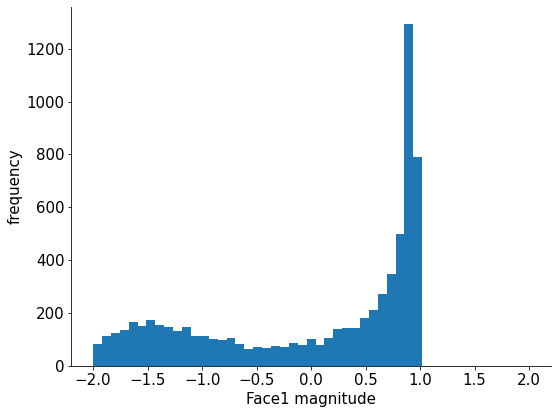

In [5]:
#@title Face PC1 Distribution
bins = np.linspace(-2, 2, num=50)
plt.figure(figsize=(8, 6))
plt.hist(zscore_face1,bins)
plt.ylabel('frequency')
plt.xlabel('Face1 magnitude')
plt.show()


# Define Brain States Based on Face Patterns

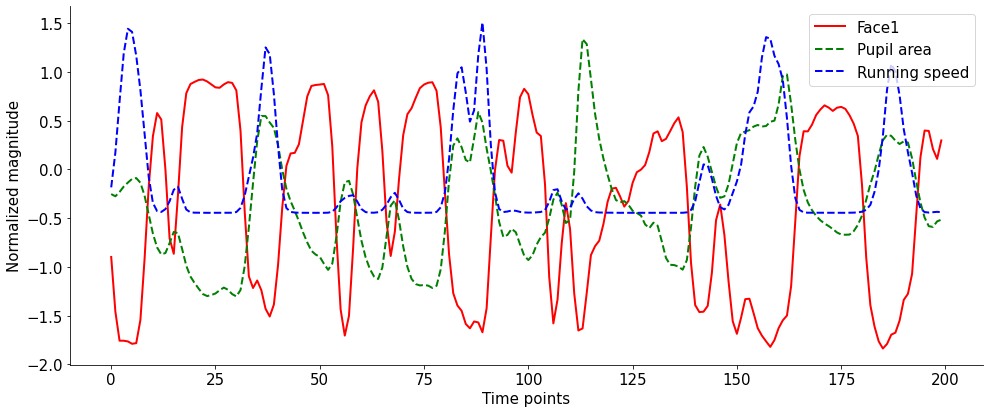

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


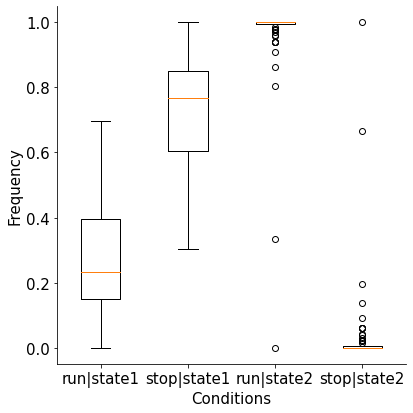

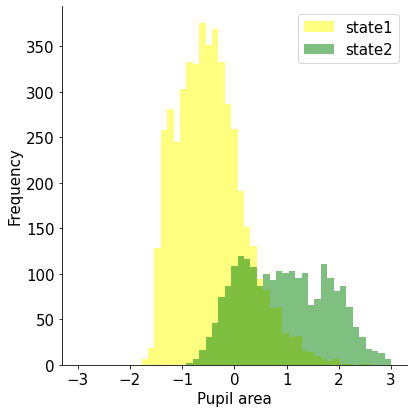

In [6]:
#@title Construct Emissions Matrix
from scipy.ndimage import gaussian_filter1d
smooth_face1 = gaussian_filter1d(zscore_face1, 1)
smooth_area = gaussian_filter1d(zscore_area, 1)
smooth_run = gaussian_filter1d(zscore_run, 1)
visualize_behavior(smooth_face1, smooth_area, smooth_run)

def con_emis_mat(state, obs):
  """
  Construct emission matrix based on state and observation

  Args:
    state (numpy array of floats) : Vector of states
    obs (numpy array of floats) : Vector of observations   

  Returns:
    emis_mat.

  """
  emis_mat = np.ones((2,2))
  emis_mat[0,0] = np.sum(np.logical_and(state,obs))/np.sum(state)
  emis_mat[0,1] = np.sum(np.logical_and(state,~obs))/np.sum(state)
  emis_mat[1,0] = np.sum(np.logical_and(~state,obs))/np.sum(~state)
  emis_mat[1,1] = np.sum(np.logical_and(~state,~obs))/np.sum(~state)
  return emis_mat

def con_emis_dist(state, obs):
  """
  Construct emission matrix based on state and observation

  Args:
    state (numpy array of floats) : Vector of states
    obs (numpy array of floats) : Vector of observations   

  Returns:
    dist_s1, dist_s2.

  """
  dist_s1 = obs[state]
  dist_s2 = obs[~state]
  return dist_s1, dist_s2


## Define states
# -0.5 was set based on the histogram
# True means brain state 1, False means brain state 2
threshold = -0.5
state = (smooth_face1 > threshold)

## Define observations
# 0.01 was set based on the plot
# True means run, False means stop
tor = 0.01
run = (smooth_run >= np.min(smooth_run)+tor)
area = smooth_area

## Compute emission probability in each time window
window = 100
repeats = len(state) // window
p_s1run = np.ones(repeats)
p_s1stop = np.ones(repeats)
p_s2run = np.ones(repeats)
p_s2stop = np.ones(repeats)
curr_state = np.reshape(state[0:window*repeats],(repeats,window))
curr_obs = np.reshape(run[0:window*repeats],(repeats,window))
for i in range(repeats):
  curr_emis_mat = con_emis_mat(curr_state[i,:],curr_obs[i,:])
  p_s1run[i] = curr_emis_mat[0,0]
  p_s1stop[i] = curr_emis_mat[0,1]
  p_s2run[i] = curr_emis_mat[1,0]
  p_s2stop[i] = curr_emis_mat[1,1]
  
dist_s1area, dist_s2area = con_emis_dist(state, area)

def visualize_boxplot(p_s1o1, p_s1o2, p_s2o1, p_s2o2):
  """
  Plots a boxplot of the data for visualization with emissions matrix.

  Args:
    p_s1o1 (numpy array of floats) : Vector of obs1 in state1
    p_s1o2 (numpy array of floats) : Vector of obs2 in state1
    p_s2o1 (numpy array of floats) : Vector of obs1 in state2
    p_s2o2 (numpy array of floats) : Vector of obs2 in state2

  Returns:
    none.

  """
  fig = plt.figure(figsize=(6,6))
  data = [p_s1o1, p_s1o2, p_s2o1, p_s2o2]
  plt.boxplot(data)
  plt.ylabel('Frequency')
  plt.xlabel('Conditions')
  plt.xticks([1, 2, 3, 4], 
             ['run|state1','stop|state1',
              'run|state2','stop|state2'])

  plt.show()

visualize_boxplot(p_s1run[~np.isnan(p_s1run)], p_s1stop[~np.isnan(p_s1stop)], 
                  p_s2run[~np.isnan(p_s2run)], p_s2stop[~np.isnan(p_s2stop)])  

def visualize_histogram(dist1, dist2):
  """
  Plots a boxplot of the data for visualization with emissions matrix.

  Args:
    dist1 (numpy array of floats) : Vector of obs in state1
    dist2 (numpy array of floats) : Vector of obs in state1

  Returns:
    none.

  """
  fig = plt.figure(figsize=(6,6))
  bins = np.linspace(-3, 3, num=50)
  plt.hist(dist1,bins,color='yellow',alpha=0.5,label='state1')
  plt.hist(dist2,bins,color='green',alpha=0.5,label='state2')
  plt.ylabel('Frequency')
  plt.xlabel('Pupil area')
  plt.legend()
  plt.show()

visualize_histogram(dist_s1area, dist_s2area)

In [7]:
#@title Construct Transition Matrix
def con_trans_mat(boolean_state):
  """
  Construct transition matrix based on state and observation

  Args:
    boolean_state (numpy array of floats) : Vector of states

  Returns:
    trans_mat.

  """
  state = np.ones(len(boolean_state))
  state[boolean_state] = 1
  state[~boolean_state] = -1
  diff_state = np.diff(state)
  p_1 = np.sum(state[:-1] == 1)/len(state[:-1])
  p_2 = np.sum(state[:-1] == -1)/len(state[:-1])
  tran1to1 = np.logical_and(state[:-1] == 1,
                            diff_state == 0)
  tran1to2 = np.logical_and(state[:-1] == 1,
                            diff_state != 0)
  tran2to1 = np.logical_and(state[:-1] == -1,
                            diff_state != 0)
  tran2to2 = np.logical_and(state[:-1] == -1,
                            diff_state == 0)
  trans_mat = np.ones((2,2))
  trans_mat[0,0] = np.sum(tran1to1)/np.sum(state[:-1] == 1)
  trans_mat[0,1] = np.sum(tran1to2)/np.sum(state[:-1] == 1)
  trans_mat[1,0] = np.sum(tran2to1)/np.sum(state[:-1] == -1)
  trans_mat[1,1] = np.sum(tran2to2)/np.sum(state[:-1] == -1)
  return trans_mat

trans_mat = con_trans_mat(state[0:200])

print('prob of state1 to state1:', f'{trans_mat[0,0]:.3f}')
print('prob of state1 to state2:', f'{trans_mat[0,1]:.3f}')
print('prob of state2 to state1:', f'{trans_mat[1,0]:.3f}')
print('prob of state2 to state2:', f'{trans_mat[1,1]:.3f}')



prob of state1 to state1: 0.910
prob of state1 to state2: 0.090
prob of state2 to state1: 0.125
prob of state2 to state2: 0.875


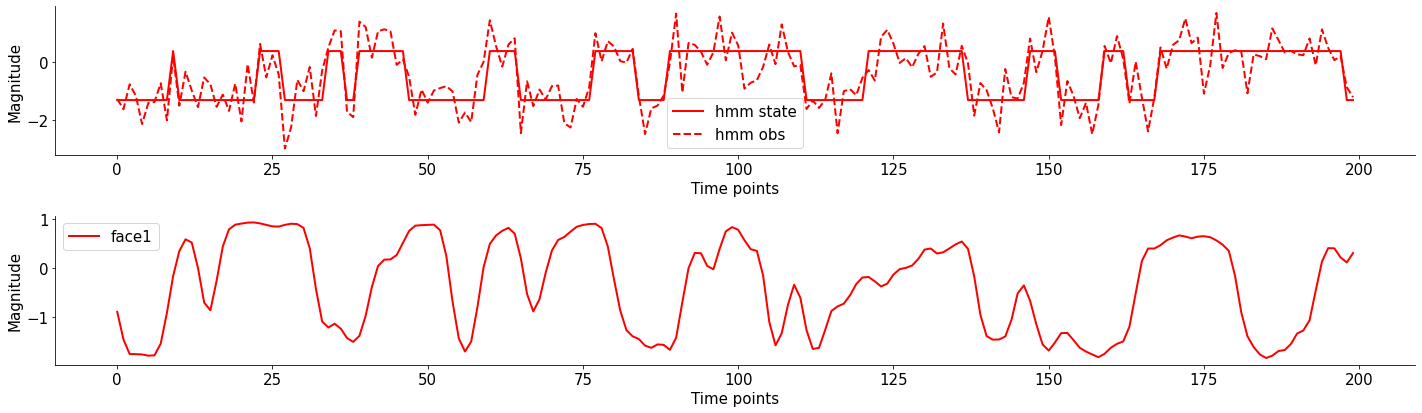

In [8]:
#@title HMM Simulation
def create_model(switch_prob1,switch_prob2,noise_level1,noise_level2,mean1,mean2,startprob):
    """Create an HMM with binary state variable and 1D Gaussian observations
    The probability to switch to the other state is `switch_prob`. Two
    observation models have mean `mean1` and `mean2` respectively. `noise_level`
    specifies the standard deviation of the observation models.

    Args:
        switch_prob (float): probability to jump to the other state
        noise_level (float): standard deviation of observation models
        mean (float): mean of observation models
        start_prob (numpy array of floats): start probability of states


    Returns:
        model (hmm.GaussianHMM instance): the described HMM
    """
    n_components = 2
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")
    model.startprob_ = np.asarray(startprob)
    # should be shape (2, 2), i.e., a transition matrix for 2 states
    
    model.transmat_ = np.array([[1. - switch_prob1, switch_prob1],
                                [switch_prob2, 1. - switch_prob2]])
    model.means_ = np.array([[mean1], [mean2]])
    
    # should be shape (2, 1, 1), i.e., 2 1x1 covariance matrices
    model.covars_ = ([[[noise_level1]],[[noise_level2]]])
    model.sample(1)
    return model

def define_params(trans_mat, state, obs):
    """Define parameters to construct HMM model.

    Args:
        trans_mat (numpy array of floats): probability of transferring
        from state 1 to state 2 and probability of transferring from
        state 2 to state 1
        state (numpy array of booleans): states
        obs (numpy array of floats): observations from each state


    Returns:
        switch_prob1 (float): probability of switching from state 1 to 
        state 2
        switch_prob2 (float): probability of switching from state 2 to 
        state 1
        noise_level1 (float): standard deviation of observation in state 1
        noise_level1 (float): standard deviation of observation in state 2
        mean1 (float): mean of observation in state 1
        mean2 (float): mean of observation in state 2
        start_prob (numpy array of floats): start probability of states
    """
    switch_prob1 = trans_mat[0,1]
    switch_prob2 = trans_mat[1,0]
    noise_level1 = np.std(obs[state])
    noise_level2 = np.std(obs[~state])
    mean1 = np.mean(obs[state])
    mean2 = np.mean(obs[~state])
    if state[0]:
      startprob=[1.0, 0.0]
    else:
      startprob=[0.0, 1.0]

    return switch_prob1, switch_prob2, noise_level1, noise_level2, mean1,\
    mean2, startprob

## Difine paramerers
switch_prob1, switch_prob2, noise_level1, noise_level2, mean1, mean2,\
startprob = define_params(trans_mat, state[0:200], smooth_face1[0:200])

## Create model
np.random.seed(101)
# nstep = len(state)
nstep = 200
model = create_model(switch_prob1,switch_prob2,
                     noise_level1,noise_level2,
                     mean1,mean2,startprob)
hmm_obs, hmm_state = model.sample(nstep)

## Plot simulation results
hmm_state_plot = np.ones(len(hmm_state))
hmm_state_plot[hmm_state == 0] = mean1
hmm_state_plot[hmm_state == 1] = mean2

def plot_hmm_simulate(hmm_state, hmm_obs, state):
  """Plots HMM states and observations for 1d states and observations.

  Args:
    hmm_state (numpy array of floats): hmm simulation of states.
    hmm_obs (numpy array of floats): hmm simulation of observations.
    state (numpy array of floats): real states.
  """

  fig = plt.figure(figsize=(20,6))
  ax1 = plt.subplot(2,1,1)
  plt.plot(hmm_state[0:200], color='red', linewidth=2, 
           label='hmm state')
  plt.plot(hmm_obs[0:200], linestyle='dashed', color='red', 
           linewidth=2, label='hmm obs')
  plt.legend()
  ax1.set(xlabel='Time points', ylabel ='Magnitude')

  ax2 = plt.subplot(2,1,2)
  plt.plot(state[0:200], color='red', linewidth=2, 
           label='face1')
  plt.legend()
  ax2.set(xlabel='Time points', ylabel ='Magnitude')
  plt.show()

plot_hmm_simulate(hmm_state_plot, hmm_obs, smooth_face1)

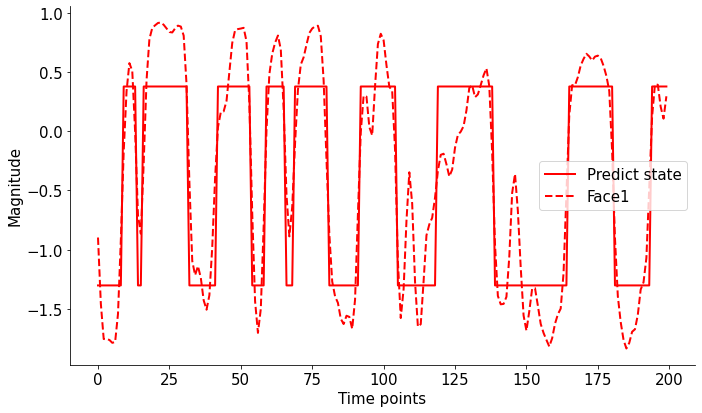

In [11]:
#@title HMM Inference
## Predit states
X = np.reshape(smooth_face1[0:200],(len(smooth_face1[0:200]),1))
model.fit(X)
state_hat = model.predict(X)
state_hat_plot = np.ones(len(state_hat))
state_hat_plot[state_hat == 0] = mean1
state_hat_plot[state_hat == 1] = mean2

def plot_hmm_predict(state_hat, state):
  """Plots HMM states and real states.

  Args:
    state_hat (numpy array of floats): hmm prediction of states.
    state (numpy array of floats): Real states.
  """

  fig = plt.figure(figsize=(10,6))
  plt.plot(state_hat[0:200], color='red', linewidth=2, 
          label='Predict state')
  plt.plot(state[0:200], linestyle='dashed', color='red', 
          linewidth=2, label='Face1')
  plt.xlabel('Time points')
  plt.ylabel('Magnitude')
  plt.legend()
  
  plt.show()

plot_hmm_predict(state_hat_plot, smooth_face1)

beh_svd_time: (7018, 1000)
beh_svd_mask: (240, 320, 1000)


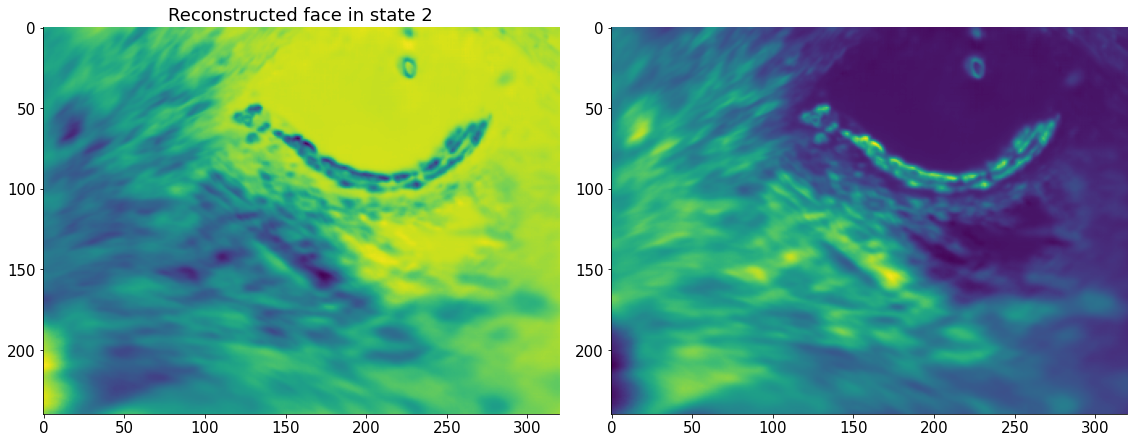

In [28]:
#@title Face Pattern in State1 and State2
print('beh_svd_time:', dat['beh_svd_time'].shape)
print('beh_svd_mask:', dat['beh_svd_mask'].shape)
row_num = dat['beh_svd_mask'].shape[0]
col_num = dat['beh_svd_mask'].shape[1]
comp_num = dat['beh_svd_mask'].shape[2]
reshape_svd_mask = np.reshape(dat['beh_svd_mask'],(row_num*col_num,comp_num))
svd_time1 = dat['beh_svd_time'][state,:]
svd_time2 = dat['beh_svd_time'][~state,:]
face_recon1 = np.mean(reshape_svd_mask @ svd_time1.T, axis = 1)
face_recon1 = np.reshape(face_recon1,(row_num, col_num))
face_recon2 = np.mean(reshape_svd_mask @ svd_time2.T, axis = 1)
face_recon2 = np.reshape(face_recon2,(row_num, col_num))
def visualize_image(face_recon1, face_recon2):
  """
  Plots a image of the data for visualization with reconstruted faces.

  Args:
    face_recon1 (numpy array of floats) : Matrix of reconstructed face in state1
    face_recon2 (numpy array of floats) : Matrix of reconstructed face in state2
    

  Returns:
    none.

  """
  plt.figure(figsize=(16,8))
  ax1 = plt.subplot(1,2,1)
  ax1.title.set_text('Reconstructed face in state 1')
  plt.imshow(face_recon1)
  ax2 = plt.subplot(1,2,2)
  plt.imshow(face_recon2)
  ax1.title.set_text('Reconstructed face in state 2')


visualize_image(face_recon1, face_recon2)

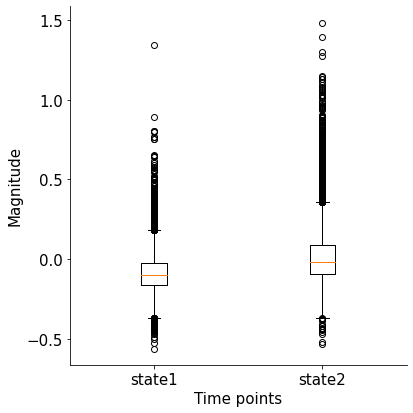

t statistic and p value: -49.357 0.000


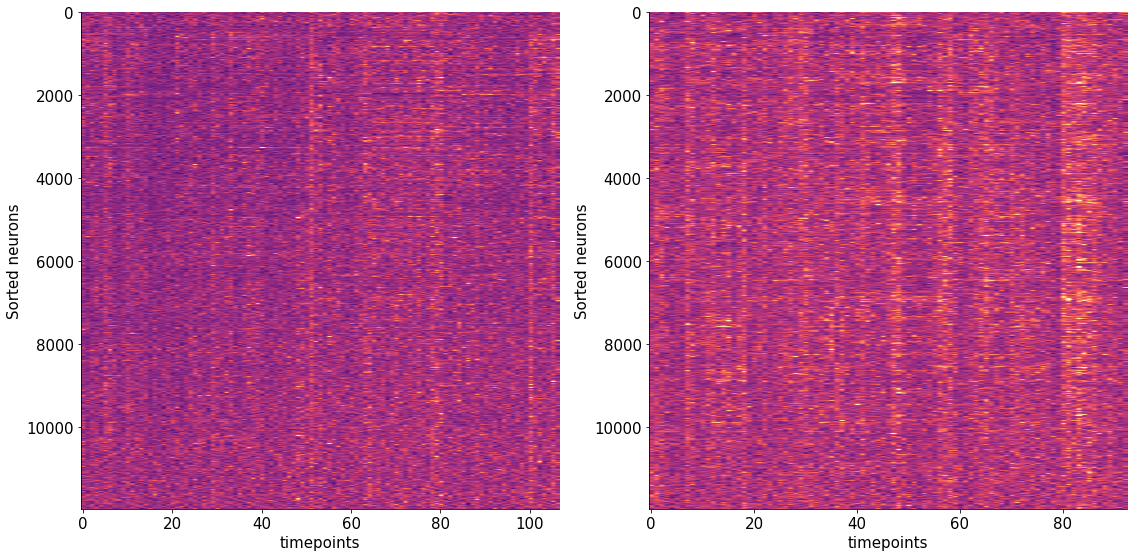

In [29]:
#@title Population Neural Responses
## Normalize neural responses
zscore_sresp = stats.zscore(dat['sresp'],axis=1)
zscore_sresp = np.nan_to_num(zscore_sresp)

## Group neural responses according to states
curr_sresp = zscore_sresp[:,0:200]
sresp1 = curr_sresp[:,state_hat == 0]
sresp2 = curr_sresp[:,state_hat == 1]

## Average neural responses
ave_sresp1 = np.mean(sresp1, axis=1)
ave_sresp2 = np.mean(sresp2, axis=1)

## Sort neurons according to depth
_, _, depth = dat['xyz']
sort_index = np.argsort(depth)
sort_sresp1 = sresp1[sort_index,:]
sort_sresp2 = sresp2[sort_index,:]

def sresp_boxplot(sresp1, sresp2):
  """
  Plots a boxplot of the data for visualization with neural responses.

  Args:
    sresp1 (numpy array of floats) : Vector of sresp in state1
    sresp2 (numpy array of floats) : Vector of sresp in state1
    

  Returns:
    none.

  """
  fig = plt.figure(figsize=(6,6))
  data = [sresp1, sresp2]
  plt.boxplot(data)
  plt.xticks([1, 2], ['state1','state2'])
  plt.xlabel('Time points')
  plt.ylabel('Magnitude')
  
  plt.show() 

def sresp_heatmap(sresp1, sresp2):
  """
  Plots a heatmap of the data for visualization with neural responses.

  Args:
    sresp1 (numpy array of floats) : Matrix of sresp in state1
    sresp2 (numpy array of floats) : Matrix of sresp in state1
    

  Returns:
    none.

  """
  plt.figure(figsize=(16,8))
  ax = plt.subplot(1,2,1)
  plt.imshow(sresp1, vmax= 1, vmin = -1, aspect = 'auto', cmap = 'magma')
  ax.set(xlabel = 'timepoints', ylabel = 'Sorted neurons');
  ax = plt.subplot(1,2,2)
  plt.imshow(sresp2, vmax= 1, vmin = -1, aspect = 'auto', cmap = 'magma')
  ax.set(xlabel = 'timepoints', ylabel = 'Sorted neurons');

sresp_boxplot(ave_sresp1, ave_sresp2) 
statistic, pvalue = stats.ttest_rel(ave_sresp1,ave_sresp2)
print('t statistic and p value:', 
      f'{statistic:.3f}',f'{pvalue:.3f}')
sresp_heatmap(sort_sresp1, sort_sresp2)